In [1]:
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
HTML('''<script src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js "></script><script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
} else {
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
''')

In [2]:
# General utilities
import numpy as np
import pandas as pd
from collections import Counter
import time
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing
from sklearn.preprocessing import StandardScaler

# Machine Learning models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Model Evaluation
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import Pipeline
from scipy import stats

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Interpretability
import shap
import dice_ml

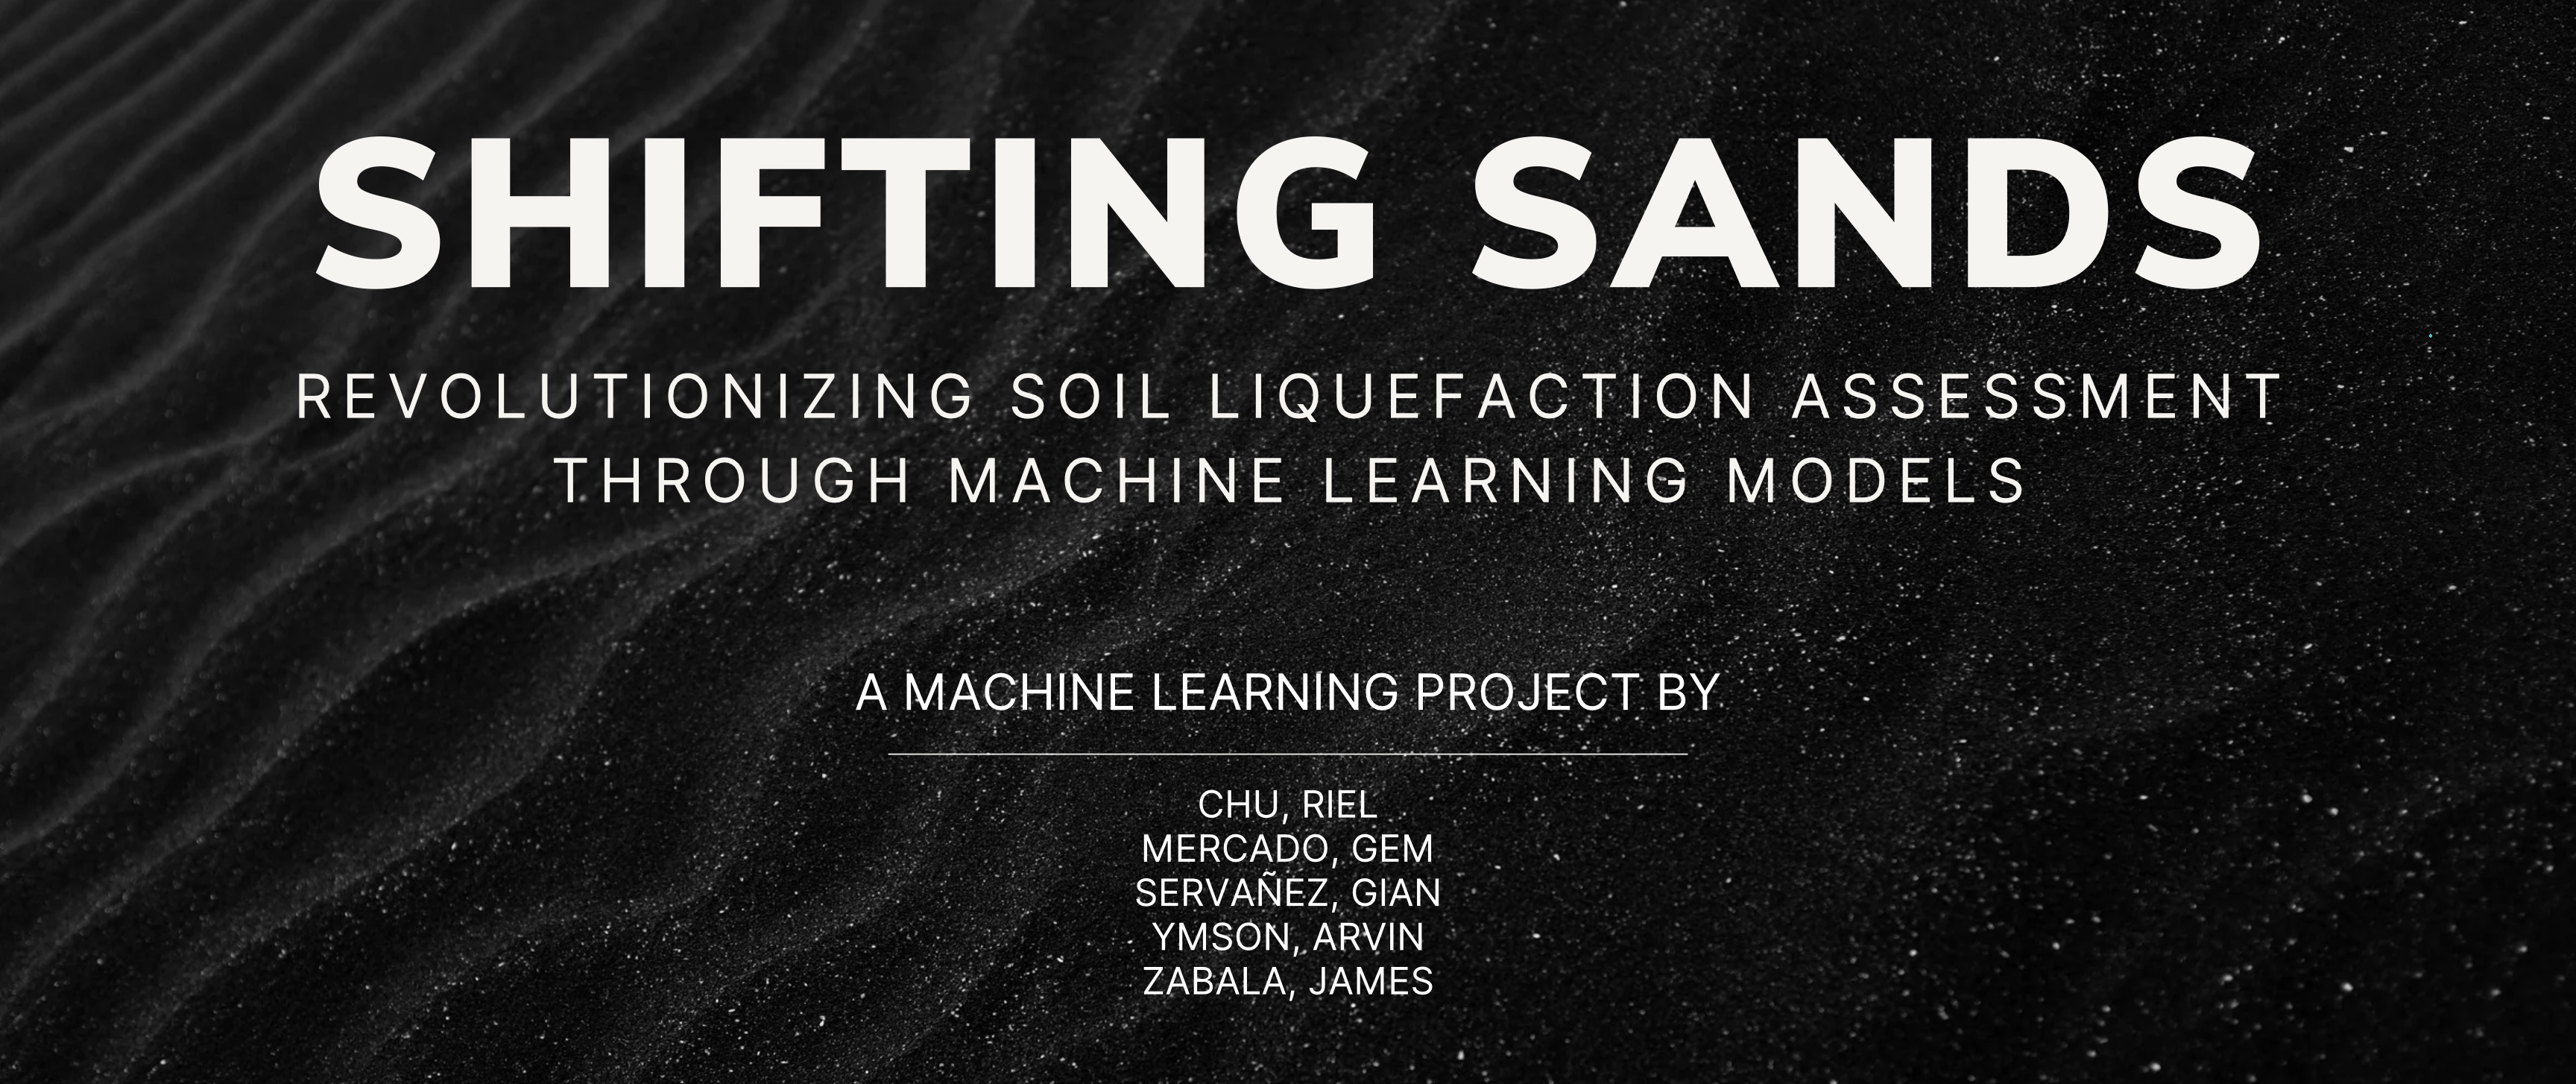

### Data Loading

In [3]:
data = pd.read_excel('soil.xlsx')
df = data.copy()

### Data Preprocessing and Feature Engineering

In [4]:
df.columns

Index(['Location', 'M', 'a', 'LIQ', 'Avg Depth', 'GWT Depth',
       'Total Vertical Stress', 'Effective Vertical Stress', 'Avg N', 'N1-60',
       'Cb', 'Ce', 'Cn', 'Cr', 'Cs', 'FC%', 'N1-60-cs', 'α', 'β', 'rd',
       'K_sigma', 'MSF', 'CSR', 'CSR norm', 'CRR', 'Assessment',
       'Data Source'],
      dtype='object')

In [5]:
df['LIQ'] = df['LIQ'].map({'Yes': 1, 'No': 0, 'Mar-ginal': 0})
df['Assessment'] = df['Assessment'].map({'Yes': 1, 'No': 0})
df['Porewater Pressure'] = df['Total Vertical Stress'] - df['Effective Vertical Stress']

### Feature Selection

In [7]:
features = [
    'a',
    'M',
    'Avg Depth',
    'GWT Depth',
    'Porewater Pressure',
    'N1-60',
    'FC%',
]

empirical_df = df.loc[:,['LIQ','Assessment']]
target = 'LIQ'

X = df[features]
y = df[target]

### Exploratory Data Analysis

Class distribution:
      0
1  133
0  121
Proportion Chance Criterion (PCC): 50.11%
1.25 * Proportion Chance Criterion: 62.64%


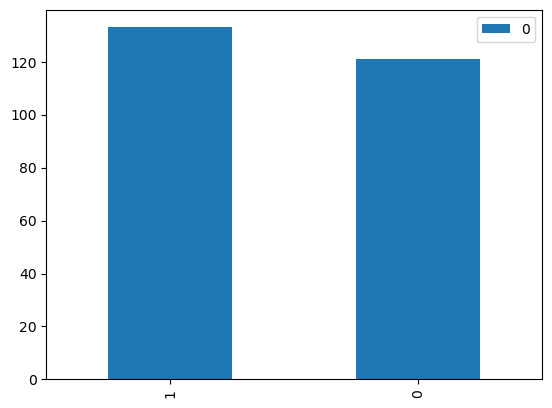

In [9]:
target = 'LIQ'

class_counts = Counter(df[target])
df_class = pd.DataFrame.from_dict(class_counts, orient="index")

# Plotting the class distribution
df_class.plot(kind="bar")

# Calculating the Proportion Chance Criterion (PCC)
proportions = df_class[0] / df_class[0].sum()
pcc = np.sum(proportions**2)

# Calculating 1.25 times PCC
augmented_pcc = 1.25 * pcc

print("Class distribution:\n", df_class)
print("Proportion Chance Criterion (PCC): {:.2f}%".format(100 * pcc))
print(
    "1.25 * Proportion Chance Criterion: {:.2f}%".format(100 * augmented_pcc))

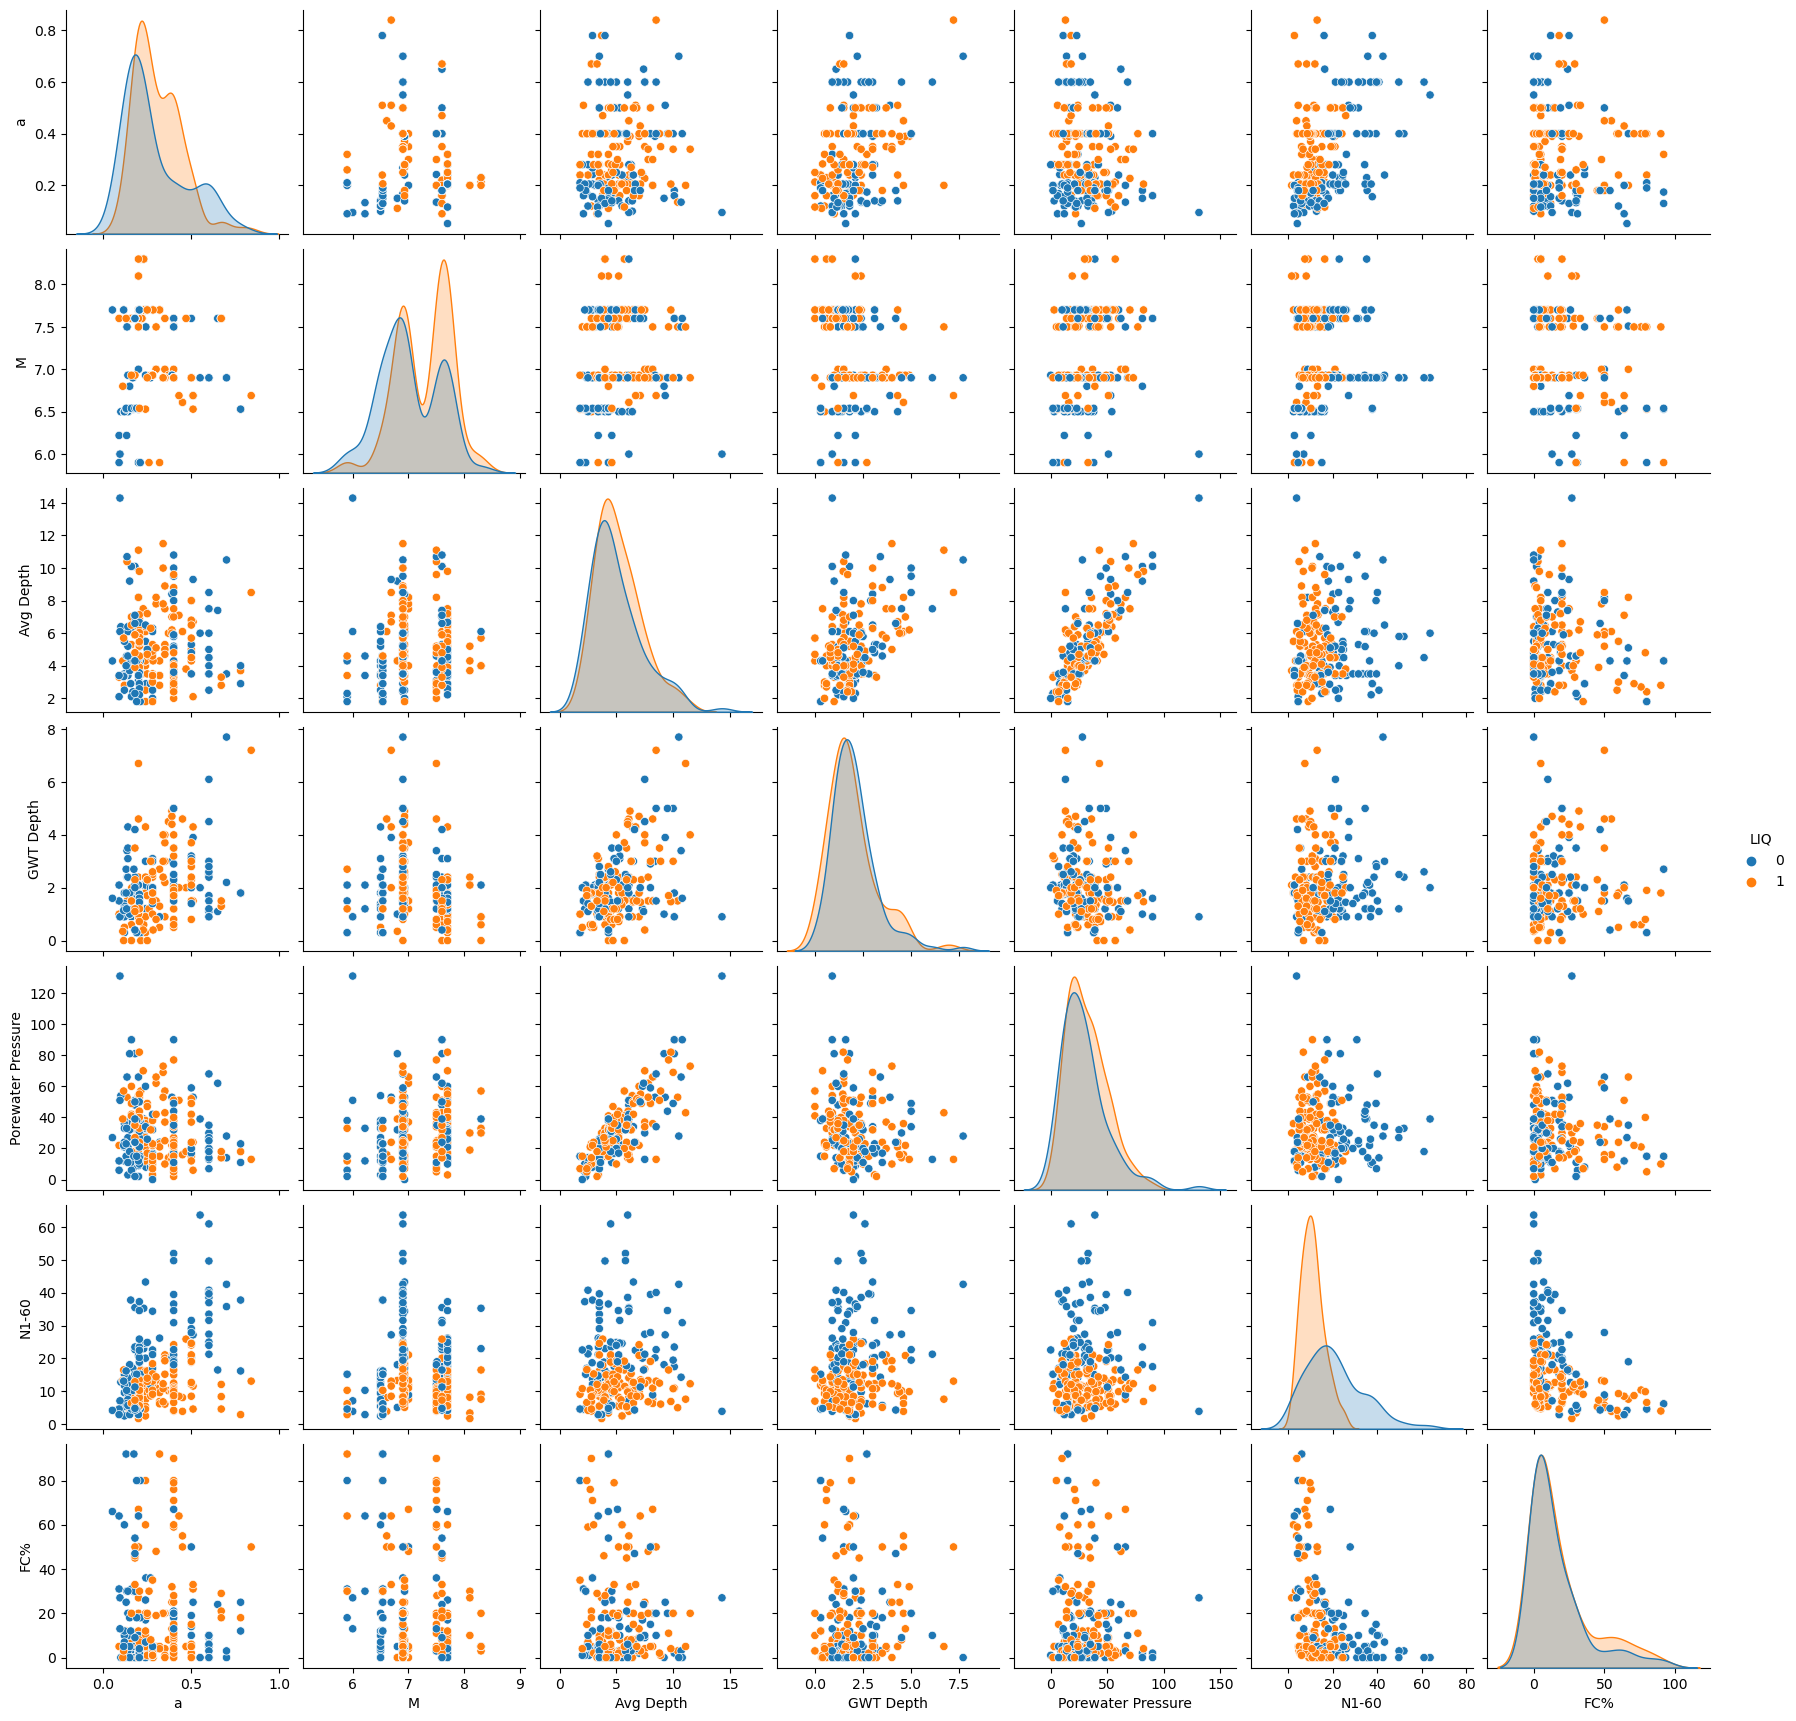

In [10]:
sns.pairplot(X.join(y), hue='LIQ')

<center><strong><em>Figure 2.</em></strong> Pairplot of the final features for ML models.</center>

### Initial Model Assessment

#### Preparing `X` and `y`

In [11]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=17)

#### GridSearch using Seven ML Models

In [12]:
models = ['XGBoost', 'GBM', 'SVC', 'RandomForest', 'DecistionTree',
          'L1 Logistic Reg', 'L2 Logistic Reg', 'KNN']

C_range = [0.01, 0.1, 0.2, 0.3, 1, 10]
alpha_range = [0.01, 0.1, 0.2, 0.3, 1, 10]
max_depth_range = range(3, 8)
learning_rate_range = [0.01, 0.1, 0.2, 0.5]
n_neighbor_range = range(3,8)

In [13]:
# Prepare the pipeline and parameter grid
steps = [('scaler', StandardScaler()), ('clf', None)]
pipe = Pipeline(steps)
param_grid = [
    {'clf': [SVC()],
         'clf__C': C_range,
         'clf__kernel': ['linear', 'rbf', 'poly']},

    {'clf': [LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)],
         'clf__C': alpha_range},

    {'clf': [LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)],
         'clf__C': alpha_range},

    {'clf': [KNeighborsClassifier()],
         'clf__n_neighbors': n_neighbor_range},

    {'clf': [RandomForestClassifier(random_state=1, n_estimators=200)],
         'clf__max_depth': max_depth_range},
    
    {'clf': [DecisionTreeClassifier(random_state=1)],
         'clf__max_depth': max_depth_range},

    {'clf': [GradientBoostingClassifier(random_state=1, n_estimators=200)],
         'clf__max_depth': max_depth_range,
         'clf__learning_rate': learning_rate_range},

    {'clf': [XGBClassifier(random_state=1, n_estimators=200)],
         'clf__max_depth': max_depth_range,
         'clf__learning_rate': learning_rate_range},
]

In [14]:
grid_search = GridSearchCV(pipe, param_grid, return_train_score=True, cv=10,
                           scoring='accuracy', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 85 candidates, totalling 850 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf', None)]),
             n_jobs=-1,
             param_grid=[{'clf': [SVC()],
                          'clf__C': [0.01, 0.1, 0.2, 0.3, 1, 10],
                          'clf__kernel': ['linear', 'rbf', 'poly']},
                         {'clf': [LogisticRegression(max_iter=1000,
                                                     penalty='l1',
                                                     solver='liblinear')],
                          'clf__C': [0.01, 0.1, 0.2, 0.3, 1, 10]},
                         {'clf': [LogisticRegression(max_iter=1000,
                                                     sol...
                                                max_cat_threshold=None,
                                                max_cat_to_onehot=None,
                                                max_delta_step=None,
                                                max_depth=None, max_leaves=None,
                                                min_child_weight=None,
                                                missing=nan,
                                                monotone_constraints=None,
                                                n_estimators=200, n_jobs=None,
                                                num_parallel_tree=None,
                                                predictor=None, random_state=1, ...)],
                          'clf__learning_rate': [0.01, 0.1, 0.2, 0.5],
                          'clf__max_depth': range(3, 8)}],
             return_train_score=True, scoring='accuracy', verbose=1)

In [15]:
cv_results1 = pd.DataFrame(grid_search.cv_results_)
cv_results1['param_clf'] = cv_results1['param_clf'].apply(str)
result1 = cv_results1.groupby('param_clf').max('rank_test_score') \
            [['mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']] \
            .sort_values('mean_test_score', ascending=False)
result1.index = models

In [16]:
result1

mean_train_score  std_train_score  mean_test_score  \
XGBoost                  0.999512         0.011068         0.868379   
GBM                      1.000000         0.006325         0.850988   
SVC                      0.942489         0.019640         0.836957   
RandomForest             0.983919         0.010507         0.828854   
DecistionTree            0.984407         0.018154         0.806324   
L1 Logistic Reg          0.825058         0.014491         0.802569   
L2 Logistic Reg          0.825548         0.014965         0.798419   
KNN                      0.874762         0.012089         0.798024   

                 std_test_score  
XGBoost                0.093406  
GBM                    0.109101  
SVC                    0.102784  
RandomForest           0.079515  
DecistionTree          0.081745  
L1 Logistic Reg        0.086615  
L2 Logistic Reg        0.103790  
KNN                    0.097938

### Select Best Model and Provide Parameters to Beat Mean Score of Empirical Method

#### XGBoost v. Empirical Method Across 30 Different TrainVal-Test Splits

In [17]:
m_train = []
m_test = []
e_test = []
for n in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=n)
    param_grid = [
        {'max_depth': [3,4,5,6,7],
         'learning_rate': [0.1, 0.2, 0.3, 0.5],
        }
    ]

    grid_search = GridSearchCV(XGBClassifier(n_estimators=200, random_state=1),
                               param_grid,
                               return_train_score=True,
                               cv=100,
                               scoring='accuracy',
                               n_jobs=-1,
                               verbose=1)

    grid_search.fit(X_train, y_train)
    model = grid_search.best_estimator_
    m_tr = model.score(X_train, y_train)
    m_ts = model.score(X_test, y_test)
    m_train.append(m_tr)
    m_test.append(m_ts)
    test_score = accuracy_score(model.predict(X_test), df.loc[X_test.index,['LIQ']])
    test_index = X_test.index
    emp_acc = accuracy_score(empirical_df.loc[test_index,['LIQ']],
                               empirical_df.loc[test_index,['Assessment']])
    e_test.append(emp_acc)
    print(f"{m_tr:.4f}   |   {m_ts:.4f}   |   {emp_acc:.4f}")

Fitting 100 folds for each of 20 candidates, totalling 2000 fits
0.9956   |   0.6923   |   0.7692
Fitting 100 folds for each of 20 candidates, totalling 2000 fits
1.0000   |   0.7308   |   0.6538
Fitting 100 folds for each of 20 candidates, totalling 2000 fits
0.9956   |   0.8077   |   0.8077
Fitting 100 folds for each of 20 candidates, totalling 2000 fits
1.0000   |   0.9615   |   0.8462
Fitting 100 folds for each of 20 candidates, totalling 2000 fits
1.0000   |   0.9231   |   0.8846
Fitting 100 folds for each of 20 candidates, totalling 2000 fits
1.0000   |   0.9231   |   0.9615
Fitting 100 folds for each of 20 candidates, totalling 2000 fits
1.0000   |   0.8077   |   0.8077
Fitting 100 folds for each of 20 candidates, totalling 2000 fits
1.0000   |   0.8846   |   0.9231
Fitting 100 folds for each of 20 candidates, totalling 2000 fits
1.0000   |   0.7692   |   0.7308
Fitting 100 folds for each of 20 candidates, totalling 2000 fits
1.0000   |   0.8077   |   0.8462
Fitting 100 folds fo

In [18]:
print(f'Train Mean: {np.mean(m_train):.4f}     |   Test Mean: {np.mean(m_test):.4f}   |   Empirical Score: {np.mean(e_test):.4f}')
print(f'Train std:  {np.std(m_train):.4f}     |   Test std: {np.std(m_test):.4f}    |   Empirical std:{np.std(e_test):.4f}')

Train Mean: 0.9995     |   Test Mean: 0.8469   |   Empirical Score: 0.8300
Train std:  0.0014     |   Test std: 0.0748    |   Empirical std:0.0738


#### T-test

In [19]:
diffs = np.array(m_test)-np.array(e_test)
t_stat, p_value = stats.ttest_1samp(diffs, popmean=0, alternative='greater')
p_value

0.031143883662779304

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=325)
param_grid = [
    {'max_depth': [3,4,5,6,7],
     'learning_rate': [0.1, 0.2, 0.3, 0.5],
    }
]

grid_search = GridSearchCV(XGBClassifier(n_estimators=200, random_state=206),
                           param_grid,
                           return_train_score=True,
                           cv=100,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_
m_tr = model.score(X_train, y_train)
m_ts = model.score(X_test, y_test)
test_score = accuracy_score(model.predict(X_test), df.loc[X_test.index,['LIQ']])
test_index = X_test.index
emp_acc = accuracy_score(empirical_df.loc[test_index,['LIQ']],
                           empirical_df.loc[test_index,['Assessment']])
# e_test.append(emp_acc)
print(f"Train Accuracy: {m_tr:.4f}   |   Test Accuracy: {m_ts:.4f}   |   Empirical Accuracy: {emp_acc:.4f}")

Fitting 100 folds for each of 20 candidates, totalling 2000 fits
Train Accuracy: 1.0000   |   Test Accuracy: 0.7692   |   Empirical Accuracy: 0.6923


### SHAP for Global Interpretability

In [23]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
explanation = explainer(X_test)

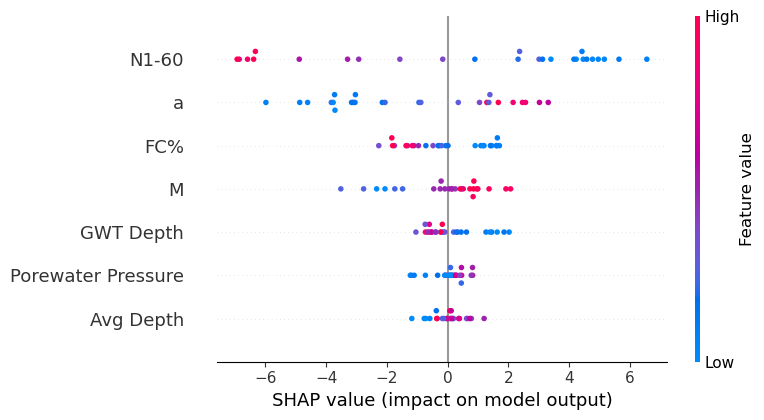

In [24]:
# Visualization
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

<left><strong><em>Figure 3.</em></strong> SHAP Beeswarm plot for global interpretability.</left>

### SHAP for Instance-Level Interpretability

In [25]:
idx = list(X_test.index).index(159)
shap.plots.waterfall(explanation[idx], max_display=14)

### DiCE – Prescriptive Analytics

In [26]:
import dice_ml
dice_model = dice_ml.Model(model=model, backend='sklearn')
dice_data = dice_ml.Data(
    dataframe=X_train.join(y_train),
    continuous_features=X_train.columns.tolist(),
    outcome_name='LIQ')
dice_exp = dice_ml.Dice(dice_data, dice_model, method='genetic')

In [27]:
cfes1 = dice_exp.generate_counterfactuals(
    X_test.iloc[[idx]],
    total_CFs=3,
    desired_class="opposite",
    features_to_vary=['N1-60']
)
cfes1.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

Query instance (original outcome : 1)


a     M  Avg Depth  GWT Depth  Porewater Pressure  N1-60  FC%  LIQ
0  0.18  6.93        5.9        3.5                  24    5.1   50    1


Diverse Counterfactual set (new outcome: 0)


a    M Avg Depth GWT Depth Porewater Pressure N1-60 FC%  LIQ
0  0.2  6.9         -         -                  -  10.3   -  0.0
0  0.2  6.9         -         -                  -  11.1   -  0.0
0  0.2  6.9         -         -                  -  11.8   -  0.0